# Week 3 Back Propagation
We introduce back propagation in numpy and pytorch respectively. 


If you have some questions or suggestion about **BackPropagation with Numpy**, contact Jiaxin Zhuang or email(zhuangjx5@mail2.sysu.edu.cn) 

## 1. Simple expressions and interpretation of the gradient

### 1.1 Simple expressions
Lets start simple so that we can develop the notation and conventions for more complex expressions. Consider a simple multiplication function of two numbers $f(x,y)=xy$. It is a matter of simple calculus to derive the partial derivative for either input:



$$f(x,y) = x y \hspace{0.5in} \rightarrow \hspace{0.5in} \frac{\partial f}{\partial x} = y \hspace{0.5in} \frac{\partial f}{\partial y} = x$$



In [1]:
# set some inputs
x1 = -2; x2 = 5;

In [2]:
# perform the forward pass
f = x1 * x2 # f becomes -10

In [3]:
# perform the backward pass (backpropagation) in reverse order:
# backprop through f = x * y
dfdx1 = x2 # df/dx = y, so gradient on x becomes 5
print("gradient on x is {:2}".format(dfdx1))
dfdx2 = x1 # df/dy = x, so gradient on y becomes -2
print('gradient on y is {:2}'.format(dfdx2))

gradient on x is  5
gradient on y is -2


### 1.2 interpretation of the gradient
**Interpretation**:The derivatives indicate the rate of change of a function with respect to that variable surrounding an infinitesimally small region near a particular point:
$$\frac{df(x)}{dx} = \lim_{h\ \to 0} \frac{f(x + h) - f(x)}{h}$$
In other words, the derivative on each variable tells you the sensitivity of the whole expression on its value.As mentioned, the gradient $\nabla f$ is the vector of partial derivatives, so we have that $\nabla f = [\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}] = [y, x]$. 

## 2. Compound expressions with chain rule

### 2.1 Simple examples for chain rule
Lets now start to consider more complicated expressions that involve multiple composed functions, such as $f(x,y,z) = (x + y) z$.

This expression is still simple enough to differentiate directly, but we’ll take a particular approach to it that will be helpful with understanding the intuition behind backpropagation. 

In particular, note that this expression can be broken down into two expressions: $q=x+y$ and $f=qz$. As seen in the previous section,$f$ is just multiplication of $q$ and $z$, so $\frac{\partial f}{\partial q} = z, \frac{\partial f}{\partial z} = q$,and $q$ is addition of $x$ and $y$ so $\frac{\partial q}{\partial x} = 1, \frac{\partial q}{\partial y} = 1$.

However, we don’t necessarily care about the gradient on the intermediate value $q$ - the value of $\frac{\partial f}{\partial q}$ is not useful. Instead, we are ultimately interested in the gradient of $f$ with respect to its inputs $x$,$y$,$z$. 

The chain rule tells us that the correct way to “chain” these gradient expressions together is through multiplication. For example, $\frac{\partial f}{\partial x} = \frac{\partial f}{\partial q} \frac{\partial q}{\partial x}$. In practice this is simply a **multiplication** of the two numbers that hold the two gradients. Lets see this with an example:

In [4]:
# set some inputs
x = -2; y = 5; z = -4  

In [5]:
# perform the forward pass
q = 2*x + y # q becomes 1
f = q * z # f becomes -4
print(q, f)

1 -4


In [6]:
# perform the backward pass (backpropagation) in reverse order:
# first backprop through f = q * z = (2*x+y) * z
dfdz = q # df/dz = q, so gradient on z becomes 3
dfdq = z # df/dq = z, so gradient on q becomes -4
# now backprop through q = x + y
dfdx = 2.0 * dfdq # dq/dx = 1. And the multiplication here is the chain rule!
dfdy = 1.0 * dfdq # dq/dy = 1
print('df/dx is {:2}'.format(dfdx))
print('df/dy is {:2}'.format(dfdy))

df/dx is -8.0
df/dy is -4.0


### 2.2 Intuitive understanding of backpropagation
Notice that backpropagation is a beautifully local process. 
Every gate in a circuit diagram gets some inputs and can right away compute two things: 
1. its output value and 
2. the local gradient of its inputs with respect to its output value. 

## 3. Practice: Writing a simple Feedforward Neural Network 

### 3.1 Outline
We would implement a simple feedforward neural network by using **numpy**. Thus, we need to define network and implement the forward pass as well as the backword propagation.

1. Define a simpel feedforward neural netork, with 1 hidden layer. Implement **forward** and **backward**
2. Load data from local csv file with **pandas**, which contains some training and testing dots, generated by 3 different gaussian distribution.(different mean and std).
3. Define some functions for visualization and training
4. Training and predicting every epoch
6. plot the distribution of the points' label and the predictions

In [7]:
# Load necessary module for later
import numpy as np
import pandas as pd
np.random.seed(1024)

### 3.2  Define a Feedforward Neural Netowk,  implement forward and backward
A simple Neural Network with 1 hidden layer.

```
                                   Networks Structure
                         
                                    Input        Weights            Output
Hidden Layer                     [batch_size, 2] x [2,5]   ->   [batch_size, 5]
activation function(sigmoid)     [batch_size, 5]           ->   [batch_size, 5]
Classification Layer             [batch_size, 5] x [5,3]   ->   [batch_size, 3]
activation function(sigmoid)     [batch_size, 3]           ->   [batch_size, 3]
```

According to training and testing data. Each points is in two-dimension space, and there is three categories. And predictions would be a one-hot vector, like \[0 0 1\] , \[1 0 0\], \[0 1 0\]

In [8]:
w1_initialization = np.random.randn(2, 5)  
w2_initialization = np.random.randn(5, 3)  

In [9]:
w2_initialization

array([[-0.06510141,  0.80681666, -0.5778176 ],
       [ 0.57306064, -0.33667496,  0.29700734],
       [-0.37480416,  0.15510474,  0.70485719],
       [ 0.8452178 , -0.65818079,  0.56810558],
       [ 0.51538125, -0.61564998,  0.92611427]])

In [10]:
class FeedForward_Neural_Network(object):
    def __init__(self, learning_rate):
        self.input_channel = 2  #  number of input neurons
        self.output_channel = 3 #  number of output neurons
        self.hidden_channel = 5 # number of hidden neurons
        self.learning_rate = learning_rate
        
        # weights initialization
        # Usually, we use random or uniform initialzation to initialize weight
        # For simplicity, here we use same array to initialze 
#         np.random.randn(self.input_channel, self.hidden_channel) 
        # (2x5) weight matrix from input to hidden layer
        self.weight1 = np.array([[ 2.12444863,  0.25264613,  1.45417876,  0.56923979,  0.45822365],
                                 [-0.80933344,  0.86407349,  0.20170137, -1.87529904, -0.56850693]])
         
        # (5x3) weight matrix from hidden to output layer
#         np.random.randn(self.hidden_channel, self.output_channel)  
        self.weight2 = np.array([ [-0.06510141,  0.80681666, -0.5778176 ],
                               [ 0.57306064, -0.33667496,  0.29700734],
                               [-0.37480416,  0.15510474,  0.70485719],
                               [ 0.8452178 , -0.65818079,  0.56810558],
                               [ 0.51538125, -0.61564998,  0.92611427]])

    
    def forward(self, X):
        """forward propagation through our network
        """
        # dot product of X (input) and first set of 3x2 weights
        self.h1 = np.dot(X, self.weight1)  
        # activation function
        self.z1 = self.sigmoid(self.h1)  
        # dot product of hidden layer (z2) and second set of 3x1 weights
        self.h2 = np.dot(self.z1, self.weight2) 
        # final activation function
        o = self.sigmoid(self.h2)
        return o
    
    def backward(self, X, y, o):
        """Backward, compute gradient and update parameters
        Inputs:
            X: data, [batch_size, 2]
            y: label, one-hot vector, [batch_size, 3]
            o: predictions, [batch_size, 3]
        """
        # backward propgate through the network
        self.o_error = y - o  # error in output
         # applying derivative of sigmoid to error  delata L
        self.o_delta = self.o_error * self.sigmoid_prime(o) 

        # z1 error: how much our hidden layer weights contributed to output error
        self.z1_error = self.o_delta.dot(self.weight2.T)  
        # applying derivative of sigmoid to z1 error
        self.z1_delta = self.z1_error * self.sigmoid_prime(self.z1)  

        # adjusting first set (input --> hidden) weights
        self.weight1 += X.T.dot(self.z1_delta) * self.learning_rate  
        # adjusting second set (hidden --> output) weights
        self.weight2 += self.z1.T.dot(self.o_delta) * self.learning_rate 
        
    def sigmoid(self, s):
        """activation function
        """
        return 1 / (1 + np.exp(-s))

    def sigmoid_prime(self, s):
        """derivative of sigmoid
        """
        return s * (1 - s)

### 3.3 Loading Data From local csv by using Pandas

In [11]:
# Import Module
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math

In [12]:
train_csv_file = './labels/train.csv'
test_csv_file = './labels/test.csv'
# Load data from csv file, without header
train_frame = pd.read_csv(train_csv_file, encoding='utf-8', header=None)
test_frame = pd.read_csv(test_csv_file, encoding='utf-8', header=None)

In [13]:
# show data in Dataframe format (defined in pandas)
train_frame

,0,1,2
0,11.834241,11.866105,1
1,8.101150,9.324800,1
2,11.184679,1.196726,2
3,8.911888,-0.044024,2
4,9.863982,0.151162,2
5,9.427897,-0.598807,2
6,10.038352,2.133938,2
7,11.149009,-0.726649,2
8,9.041540,2.972213,2
9,13.413336,-3.174030,2


In [14]:
# obtain data from specific columns

# obtain data from first and second columns and convert into narray
train_data = train_frame.iloc[:,0:2].values 
# obtain labels from third columns and convert into narray
train_labels = train_frame.iloc[:,2].values 
# obtain data from first and second columns and convert into narray
test_data = test_frame.iloc[:,0:2].values
# obtain labels from third columns and convert into narray
test_labels = test_frame.iloc[:,2].values

In [15]:
# train & test data shape
print(train_data.shape)
print(test_data.shape)
# train & test labels shape
print(train_labels.shape)
print(test_labels.shape)

(210, 2)
(90, 2)
(210,)
(90,)


### 3.4 Define some function for visualization and training

In [16]:
def plot(data, labels, caption):
    """plot the data distribution, !!YOU CAN READ THIS LATER, if you are interested
    """
    colors = cm.rainbow(np.linspace(0, 1, len(set(labels))))
    for i in set(labels):
        xs = []
        ys = []
        for index, label in enumerate(labels):
            if label == i:
                xs.append(data[index][0])
                ys.append(data[index][1])
        plt.scatter(xs, ys, colors[int(i)])    
    plt.title(caption)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

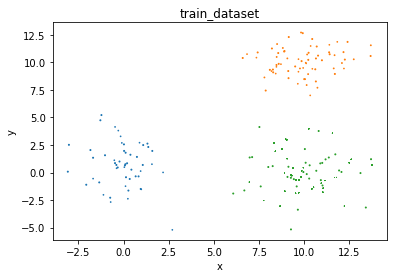

In [17]:
plot(train_data, train_labels, 'train_dataset')

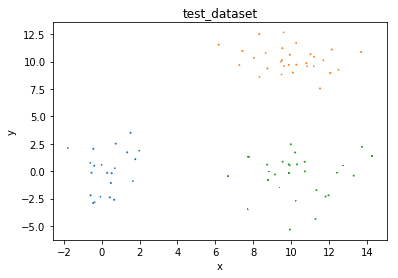

In [18]:
plot(test_data, test_labels, 'test_dataset')

In [19]:
def int2onehot(label):
    """conver labels into one-hot vector, !!YOU CAN READ THIS LATER, if you are interested
    Args:
        label: [batch_size]
    Returns:
        onehot: [batch_size, categories]
    """
    dims = len(set(label))
    imgs_size = len(label)
    onehot = np.zeros((imgs_size, dims))
    onehot[np.arange(imgs_size), label] = 1
    return onehot

In [20]:
# convert labels into one hot vector
train_labels_onehot = int2onehot(train_labels)
test_labels_onehot = int2onehot(test_labels)
print(train_labels_onehot.shape)
print(train_labels_onehot.shape)

(210, 3)
(210, 3)


In [21]:
def get_accuracy(predictions, labels):
    """Compute accuracy, !!YOU CAN READ THIS LATER, if you are interested
    Inputs: 
        predictions:[batch_size, categories] one-hot vector
        labels: [batch_size, categories]
    """
    predictions = np.argmax(predictions, axis=1)
    labels = np.argmax(labels, axis=1)
    all_imgs = len(labels)
    predict_true = np.sum(predictions == labels)
    return predict_true/all_imgs

In [22]:
# Please read this function carefully, related to implementation of GD, SGD, and mini-batch
def generate_batch(train_data, train_labels, batch_size):
    """Generate batch
    when batch_size=len(train_data), it's GD
    when batch_size=1, it's SGD
    when batch_size>1 & batch_size<len(train_data), it's mini-batch, usually, batch_size=2,4,8,16...
    """
    iterations = math.ceil(len(train_data)/batch_size)
    for i in range(iterations):
        index_from = i*batch_size
        index_end = (i+1)*batch_size
        yield (train_data[index_from:index_end], train_labels[index_from:index_end])

In [23]:
def show_curve(ys, title):
    """plot curlve for Loss and Accuacy, !!YOU CAN READ THIS LATER, if you are interested
    Args:
        ys: loss or acc list
        title: Loss or Accuracy
    """
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('{} Curve:'.format(title))
    plt.xlabel('Epoch')
    plt.ylabel('{} Value'.format(title))
    plt.show()

### 3.5 Training model and make predictions

In [24]:
learning_rate = 0.1

In [25]:
epochs = 400 # training epoch

In [26]:
batch_size = len(train_data) # GD
# batch_size = 1               # SGD
# batch_size = 8               # mini-batch

In [27]:
model = FeedForward_Neural_Network(learning_rate) # declare a simple feedforward neural model

losses = []
accuracies = []

for i in range(epochs):
    loss = 0
    for index, (xs, ys) in enumerate(generate_batch(train_data, train_labels_onehot, batch_size)):
        predictions = model.forward(xs) # forward phase
        loss += 1/2 * np.mean(np.sum(np.square(ys-predictions), axis=1)) # Mean square error
        model.backward(xs, ys, predictions) # backward phase
        
    losses.append(loss)
    
    # train dataset acc computation
    predictions = model.forward(train_data)
    # compute acc on train dataset
    accuracy = get_accuracy(predictions, train_labels_onehot)
    accuracies.append(accuracy)
    
    if i % 50 == 0:
        print('Epoch: {}, has {} iterations'.format(i, index+1))
        print('\tLoss: {:.4f}, \tAccuracy: {:.4f}'.format(loss, accuracy))
        
test_predictions = model.forward(test_data)
# compute acc on test dataset
test_accuracy = get_accuracy(test_predictions, test_labels_onehot)
print('Test Accuracy: {:.4f}'.format(test_accuracy))

Epoch: 0, has 1 iterations
	Loss: 0.4185, 	Accuracy: 0.3381
Epoch: 50, has 1 iterations
	Loss: 0.0309, 	Accuracy: 0.9571
Epoch: 100, has 1 iterations
	Loss: 0.0304, 	Accuracy: 0.9762
Epoch: 150, has 1 iterations
	Loss: 0.0092, 	Accuracy: 1.0000
Epoch: 200, has 1 iterations
	Loss: 0.0909, 	Accuracy: 0.8333
Epoch: 250, has 1 iterations
	Loss: 0.0400, 	Accuracy: 0.9571
Epoch: 300, has 1 iterations
	Loss: 0.0225, 	Accuracy: 0.9762
Epoch: 350, has 1 iterations
	Loss: 0.0204, 	Accuracy: 0.9810
Test Accuracy: 0.9444


##### !!! Homework 1.   Describe the training procedure, based on codes above. 

BP神经网络的训练流程主要分为神经网络的初始化、信号的前向传播、误差的反向传播、权重的更新四个步骤。

* 神经网络的初始化：初始化输入层、隐层、输出层的节点，同时初始化各层之间的权重，选择激励函数、学习速率等参数。这里各层节点分别为3、5、2，权重固定一个值，而不是均匀随机生成，激励函数选择Sigmoid函数。
* 信号的前向传播：输入训练集样例，通过权重的选择，以及激励函数的作用，最终得到一个输出值。
* 误差的反向传播：比较输出值和训练集样例的标签，计算出误差，并逐步反向传播至隐层、输入层。
* 权重的更新：根据下一层传回的误差和学习速率，对当前权重进行更新。

BP神经网络的训练首先初始化神经网络，然后循环训练代数次。

在训练循环中，会根据预先选择的梯度下降法对数据进行分割，每份数据都依次进行前向传播、反向传播、更新权重过程。其中，梯度下降将不分割数据，而随机梯度下降法每次只使用一个样例，mini批梯度下降法根据参数决定每份数据的样例数。

训练结束后，可使用测试集样例来检测当前BP神经网络的正确率。
   

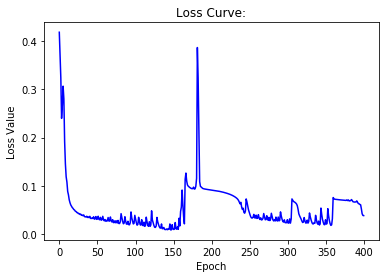

In [28]:
# Draw losses curve using losses 
show_curve(losses, 'Loss')

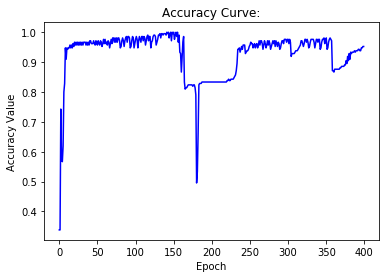

In [29]:
# Draw Accuracy curve using accuracies
show_curve(accuracies, 'Accuracy')

##### !!! Howework 2 
set learning rate = 0.01 to train the model and show two curve below

In [30]:
def training(learning_rate, batch_size):
    model = FeedForward_Neural_Network(learning_rate) # declare a simple feedforward neural model

    losses = []
    accuracies = []

    for i in range(epochs):
        loss = 0
        for index, (xs, ys) in enumerate(generate_batch(train_data, train_labels_onehot, batch_size)):
            predictions = model.forward(xs) # forward phase
            loss += 1/2 * np.mean(np.sum(np.square(ys-predictions), axis=1)) # Mean square error
            model.backward(xs, ys, predictions) # backward phase

        losses.append(loss)

        # train dataset acc computation
        predictions = model.forward(train_data)
        # compute acc on train dataset
        accuracy = get_accuracy(predictions, train_labels_onehot)
        accuracies.append(accuracy)

        if i % 50 == 0:
            print('Epoch: {}, has {} iterations'.format(i, index+1))
            print('\tLoss: {:.4f}, \tAccuracy: {:.4f}'.format(loss, accuracy))

    test_predictions = model.forward(test_data)
    # compute acc on test dataset
    test_accuracy = get_accuracy(test_predictions, test_labels_onehot)
    print('Test Accuracy: {:.4f}'.format(test_accuracy))

    # Draw losses curve using losses 
    show_curve(losses, 'Loss')
    
    # Draw Accuracy curve using accuracies
    show_curve(accuracies, 'Accuracy')
    
    return model

Epoch: 0, has 1 iterations
	Loss: 0.4185, 	Accuracy: 0.6762
Epoch: 50, has 1 iterations
	Loss: 0.1258, 	Accuracy: 0.8667
Epoch: 100, has 1 iterations
	Loss: 0.0796, 	Accuracy: 0.9619
Epoch: 150, has 1 iterations
	Loss: 0.0559, 	Accuracy: 0.9905
Epoch: 200, has 1 iterations
	Loss: 0.0429, 	Accuracy: 1.0000
Epoch: 250, has 1 iterations
	Loss: 0.0348, 	Accuracy: 1.0000
Epoch: 300, has 1 iterations
	Loss: 0.0292, 	Accuracy: 1.0000
Epoch: 350, has 1 iterations
	Loss: 0.0252, 	Accuracy: 1.0000
Test Accuracy: 1.0000


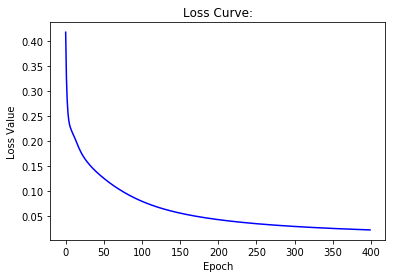

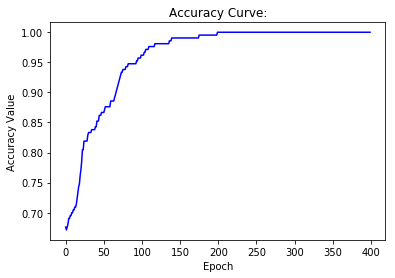

In [31]:
learning_rate = 0.01
training(learning_rate, batch_size)

##### !!! Howework 3
Use SGD and mini-batch to train model and show four curve below

Epoch: 0, has 210 iterations
	Loss: 54.0224, 	Accuracy: 0.7095
Epoch: 50, has 210 iterations
	Loss: 4.1709, 	Accuracy: 1.0000
Epoch: 100, has 210 iterations
	Loss: 2.3627, 	Accuracy: 1.0000
Epoch: 150, has 210 iterations
	Loss: 1.6888, 	Accuracy: 1.0000
Epoch: 200, has 210 iterations
	Loss: 1.4110, 	Accuracy: 1.0000
Epoch: 250, has 210 iterations
	Loss: 1.6028, 	Accuracy: 0.9952
Epoch: 300, has 210 iterations
	Loss: 1.2224, 	Accuracy: 1.0000
Epoch: 350, has 210 iterations
	Loss: 0.9073, 	Accuracy: 1.0000
Test Accuracy: 1.0000


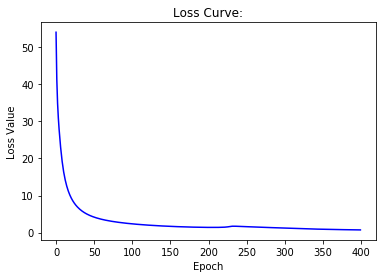

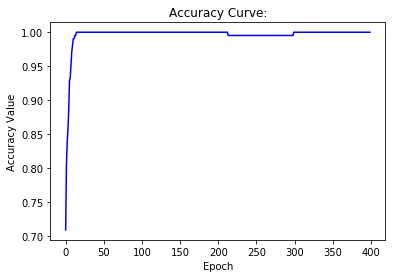

In [32]:
# SGD
learning_rate = 0.1
batch_size = 1
training(learning_rate, batch_size)

Epoch: 0, has 27 iterations
	Loss: 6.9047, 	Accuracy: 0.7048
Epoch: 50, has 27 iterations
	Loss: 0.5341, 	Accuracy: 1.0000
Epoch: 100, has 27 iterations
	Loss: 0.3030, 	Accuracy: 1.0000
Epoch: 150, has 27 iterations
	Loss: 0.2159, 	Accuracy: 1.0000
Epoch: 200, has 27 iterations
	Loss: 0.1829, 	Accuracy: 1.0000
Epoch: 250, has 27 iterations
	Loss: 0.1991, 	Accuracy: 0.9952
Epoch: 300, has 27 iterations
	Loss: 0.1500, 	Accuracy: 1.0000
Epoch: 350, has 27 iterations
	Loss: 0.1120, 	Accuracy: 1.0000
Test Accuracy: 1.0000


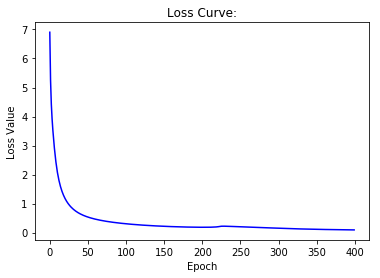

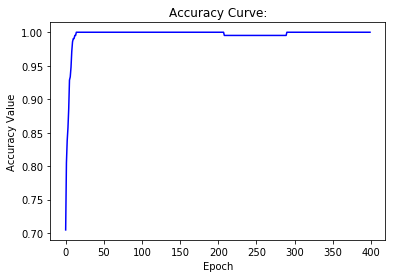

In [33]:
# mini-batch
learning_rate = 0.1
batch_size = 8
training(learning_rate, batch_size)